<a href="https://colab.research.google.com/github/matteonerini/augmented-pin-authentication/blob/main/PIN_authentication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Visualization

In this section, the .txt files are uploaded and visualized through PCA.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

urlList = []
for iUrl in range(12):
    urlList.append('https://raw.githubusercontent.com/matteonerini/augmented-pin-authentication/main/dataset/stud'+str(iUrl+1)+'.txt')

names = ['Digit','Acc_X','Acc_Y','Acc_Z','Gir_X','Gir_Y','Gir_Z','Gra_X','Gra_Y','Gra_Z',
         'Lin_X','Lin_Y','Lin_Z','Rot_Z','Ori_X','Ori_Y','M']
dataset_parts = []
for iUrl in range(12):
    dataset_parts.append(np.hstack((np.zeros((470,1))+iUrl+1, pd.read_csv(urlList[iUrl], names=names).values)))

dataset = np.vstack(dataset_parts)

# Feature scaling
X_temp = dataset[:,1:18]
y = dataset[:,0]

scaler = StandardScaler()
X = scaler.fit_transform(X_temp)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Principal Component Analysis
pca = PCA()
XPca = pca.fit(X).transform(X)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

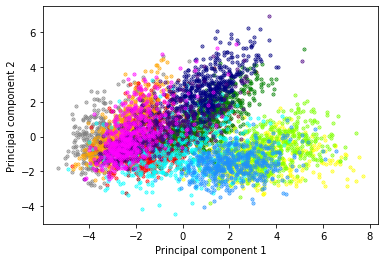

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

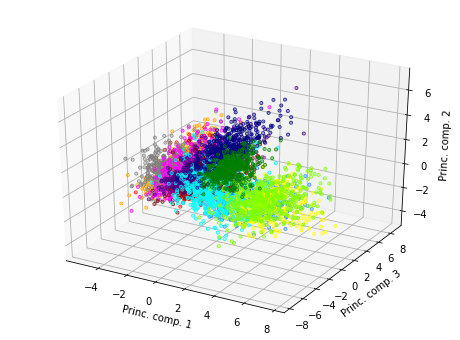

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

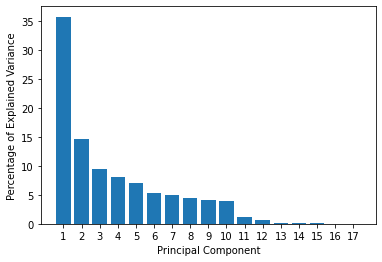

<IPython.core.display.Javascript object>

The percentage of variance explained by the top-3 PCs is: [35.8 14.6  9.5]


In [ ]:
import matplotlib.pyplot as plt
from google.colab import widgets
tb = widgets.TabBar(['PCA 2D', 'PCA 3D', 'Hist PCA'])

target_names = list(range(1, 13))
indexIs = list(range(1, 13))
colors = ['gray','maroon','red','orange','yellow','chartreuse','green','cyan','dodgerblue','navy','indigo','magenta']

## Plot PCA 2D
with tb.output_to('PCA 2D'):
    plt.figure()
    for color, i, target_name in zip(colors, indexIs, target_names):
        plt.scatter(XPca[y == i, 0], XPca[y == i, 1], color=color, alpha=.8,
                    label=target_name, lw=3, s=1)
    #plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    #plt.title('PCA of X dataset')
    plt.savefig('PCA-2D.pdf', bbox_inches='tight')

## Plot PCA 3D
with tb.output_to('PCA 3D'):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(projection='3d')
    for color, i, target_name in zip(colors, indexIs, target_names):
        ax.scatter(XPca[y == i, 0], XPca[y == i, 2],XPca[y == i, 1], color=color, alpha=.8,
                    label=target_name, lw=3, s=1)
    #plt.legend(loc='best', shadow=False, scatterpoints=1)
    ax.set_xlabel('Princ. comp. 1')
    ax.set_ylabel('Princ. comp. 3')
    ax.set_zlabel('Princ. comp. 2')
    ax.set_xlim([-5,8])
    ax.set_zlim([-4,6])
    ax.set_ylim([-4,4])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.autoscale()
    plt.savefig('PCA-3D.pdf', bbox_inches="tight")

## Scree plot PCA
with tb.output_to('Hist PCA'):
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

    plt.figure()
    #plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
    plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=[str(x) for x in range(1, len(per_var)+1)])
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Component')
    #plt.title('Scree Plot')
    plt.savefig('PCA-scree-plot.png', bbox_inches='tight')
    
print('The percentage of variance explained by the top-3 PCs is: '+str(per_var[0:3]))

# Anomaly detection for secure authentication

In this section, anomaly detection is performed.

## Data Pre-processing

The datasets are uploaded from the .txt files and pre-processed.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

urlList = []
for iUrl in range(12):
    urlList.append('https://raw.githubusercontent.com/matteonerini/augmented-pin-authentication/main/dataset/stud'+str(iUrl+1)+'.txt')

names = ['Digit','Acc_X','Acc_Y','Acc_Z','Gir_X','Gir_Y','Gir_Z','Gra_X','Gra_Y','Gra_Z',
         'Lin_X','Lin_Y','Lin_Z','Rot_Z','Ori_X','Ori_Y','M']
dataset_parts = []
for url in urlList:
    dataset_parts.append(pd.read_csv(url, names=names).values)

dataset_tot = np.vstack(dataset_parts)

# Feature scaling
scaler = StandardScaler()
dataset_tot = scaler.fit_transform(dataset_tot)
for iPart in range(12):
    dataset_parts[iPart] = scaler.transform(dataset_parts[iPart])

## Model Generation, Training and Testing of PCA and K-PCA

The dataset is randomly divided in train and test sets. The model is generated, trained and tested with different seeds. The error values are stored to plot the ROC using the scikit-learn function.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from itertools import combinations
from scipy import special
from scipy import io
from google.colab import output
import random
import time

# Options
model = 'pca' # 'pca' or 'kpca'
nDiv = 6 # 6
nComponents = 10 # 10 for PCA, 8 for K-PCA
nTrainList = [50,100,200,400] # [400] or [50,100,200,400]
test_size = 0.10 # 0.10

# Set random seed
seed = 1
random.seed(seed)
np.random.seed(seed)

# Preallocate rocMat [(nDiv x len(nTrainList)) x (500 x 2 x nDatasets) x 2]
rocMat = []
for i in range(nDiv*len(nTrainList)):
    rocMat.append([])

# Precompute all the combinations with iDiv items and the combination indexes for X_test
comb_list_all_test = []
iComb_list_all_test = []
nTest = int(len(dataset_parts[0])*test_size)
for iDiv in range(2,nDiv+1):
    comb_list_all_test.append(list(combinations(range(nTest), iDiv)))
    iComb_list_all_test.append(np.array(range(int(special.binom(nTest, iDiv)))))

# Precompute 500 combinations with iDiv items and the combination indexes for X_outl
comb_list_all_outl = []
iComb_list_all_outl = []
nOutl = nTest * (12 - 1)
for iDiv in range(2,nDiv+1):
    used_combs = list()
    while len(used_combs) < 500:
        comb = random.sample(range(nOutl), iDiv)
        comb = tuple(sorted(comb))
        if comb not in used_combs:
            used_combs.append(comb)
    comb_list_all_outl.append(used_combs)
    iComb_list_all_outl.append(np.array(range(500)))

# Split all the datasets into train and test sets
dataset_train = []
dataset_test = []
for iDataset in range(12):
    X_train, X_test = train_test_split(dataset_parts[iDataset], test_size=test_size, random_state=seed)
    dataset_train.append(X_train)
    dataset_test.append(X_test)

# Train and test over all the datasets
times = np.zeros((nDiv,12))
for iDataset in range(12):
    
    # Generate X_train, X_test, and X_outl
    X_train = dataset_train[iDataset]
    X_test = dataset_test[iDataset]
    X_outl = []
    for jDataset in range(12):
        if jDataset != iDataset:
            if not len(X_outl):
                X_outl = dataset_test[jDataset]
            else:
                X_outl = np.vstack((X_outl, dataset_test[jDataset]))
        
    # Print information on the current computation
    output.clear()
    print('Model: '+model+', '+
            'Dataset:'+str(iDataset+1)+'/12')

    # Train with all training sizes
    for iNTrain in range(len(nTrainList)):

        # Generate the model
        if model == 'pca':
            pca = PCA(n_components=nComponents)
            Xpca = pca.fit(X_train[:nTrainList[iNTrain],:])
        elif model == 'kpca':
            pca = KernelPCA(kernel='rbf',alpha=0.001,n_components=nComponents,fit_inverse_transform=True)
            Xpca = pca.fit(X_train[:nTrainList[iNTrain],:])
        else:
            print('Insert a correct model name')

        # Shuffle the X_test and X_outl sets
        np.random.shuffle(X_test)
        np.random.shuffle(X_outl)

        ## div==1 (no diversity)
        X_test_reconst = pca.inverse_transform(pca.transform(X_test))
        X_test_error = np.linalg.norm(X_test_reconst - X_test, axis=1)

        X_outl_reconst = pca.inverse_transform(pca.transform(X_outl[0:500,:]))
        X_outl_error = np.linalg.norm(X_outl_reconst - X_outl[0:500,:], axis=1)
        
        for i in range(len(X_test_error)):
            rocMat[iNTrain*nDiv+0].append([+1,-X_test_error[i]])

        for i in range(len(X_outl_error)):
            rocMat[iNTrain*nDiv+0].append([-1,-X_outl_error[i]])

        ## div!=1 (diversity)
        for iDiv in range(2,nDiv+1):
            
            # Retrieve all the combinations with iDiv items for X_test
            comb_list_test = comb_list_all_test[iDiv-2]
            iComb_list_test = iComb_list_all_test[iDiv-2]
            np.random.shuffle(iComb_list_test)

            y_test_proba_div_tmp = []
            for iComb_test in range(min(len(iComb_list_test), 500)):
                i = comb_list_test[iComb_list_test[iComb_test]]
                if   iDiv == 2: X_test_div = np.vstack((X_test[i[0],:], X_test[i[1],:]))
                elif iDiv == 3:X_test_div = np.vstack((X_test[i[0],:], X_test[i[1],:], X_test[i[2],:]))
                elif iDiv == 4: X_test_div = np.vstack((X_test[i[0],:], X_test[i[1],:], X_test[i[2],:],
                                                        X_test[i[3],:]))
                elif iDiv == 5: X_test_div = np.vstack((X_test[i[0],:], X_test[i[1],:], X_test[i[2],:],
                                                        X_test[i[3],:], X_test[i[4],:]))
                elif iDiv == 6: X_test_div = np.vstack((X_test[i[0],:], X_test[i[1],:], X_test[i[2],:],
                                                        X_test[i[3],:], X_test[i[4],:], X_test[i[5],:]))
                X_test_reconst = pca.inverse_transform(pca.transform(X_test_div))
                y_test_proba_div_comb = np.linalg.norm(X_test_reconst - X_test_div, axis=1)
                y_test_proba_div_tmp.append(np.sum(y_test_proba_div_comb))
            y_test_proba_div = np.array(y_test_proba_div_tmp)

            # Retrieve all the combinations with iDiv items for X_outl
            comb_list_outl = comb_list_all_outl[iDiv-2]
            iComb_list_outl = iComb_list_all_outl[iDiv-2]
            np.random.shuffle(iComb_list_outl)

            # Start time
            t = time.time()

            y_outl_proba_div_tmp = []
            for iComb_outl in range(500):
                i = comb_list_outl[iComb_list_outl[iComb_outl]]
                if   iDiv == 2: X_outl_div = np.vstack((X_outl[i[0],:], X_outl[i[1],:]))
                elif iDiv == 3: X_outl_div = np.vstack((X_outl[i[0],:], X_outl[i[1],:], X_outl[i[2],:]))
                elif iDiv == 4: X_outl_div = np.vstack((X_outl[i[0],:], X_outl[i[1],:], X_outl[i[2],:],
                                                        X_outl[i[3],:]))
                elif iDiv == 5: X_outl_div = np.vstack((X_outl[i[0],:], X_outl[i[1],:], X_outl[i[2],:],
                                                        X_outl[i[3],:], X_outl[i[4],:]))
                elif iDiv == 6: X_outl_div = np.vstack((X_outl[i[0],:], X_outl[i[1],:], X_outl[i[2],:],
                                                        X_outl[i[3],:], X_outl[i[4],:], X_outl[i[5],:]))
                X_outl_reconst = pca.inverse_transform(pca.transform(X_outl_div))
                y_outl_proba_div_comb = np.linalg.norm(X_outl_reconst - X_outl_div, axis=1)
                y_outl_proba_div_tmp.append(np.sum(y_outl_proba_div_comb))
            y_outl_proba_div = np.array(y_outl_proba_div_tmp)

            # Register time
            if nTrainList[iNTrain] == 400:
                dt = time.time() - t
                times[iDiv-1,iDataset] = dt
                print(str(iDiv)+', '+str(iNTrain)+', '+str(dt))

            for i in range(len(y_test_proba_div)):
                rocMat[iNTrain*nDiv+iDiv-1].append([+1,-y_test_proba_div[i]])

            for i in range(len(y_outl_proba_div)):
                rocMat[iNTrain*nDiv+iDiv-1].append([-1,-y_outl_proba_div[i]])                

# Save the .mat file
io.savemat('rocMat.mat', {'data': rocMat})
io.savemat('times.mat', {'data': times})

## Model Generation, Training and Testing of LOF and OC-SVM

The dataset is randomly divided in train and test sets. The model is generated, trained and tested with different seeds. The `decision_function` values are stored to plot the ROC using the scikit-learn function.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from itertools import combinations
from scipy import special
from scipy import io
from google.colab import output
import random
import time

# Options
model = 'lof' # 'lof' or 'ocsvm'
nDiv = 6
nTrainList = [50,100,200,400] # [400] or [50,100,200,400]
test_size = 0.10

# Set random seed
seed = 1
random.seed(seed)
np.random.seed(seed)

# Preallocate rocMat [nDiv x (500 x 2 x nDatasets) x 2]
rocMat = []
#for i in range(len(nTrainList)):
for i in range(nDiv*len(nTrainList)):
    rocMat.append([])

# Precompute all the combinations with iDiv items and the combination indexes for X_test
comb_list_all_test = []
iComb_list_all_test = []
nTest = int(len(dataset_parts[0])*test_size)
for iDiv in range(2,nDiv+1):
    comb_list_all_test.append(list(combinations(range(nTest), iDiv)))
    iComb_list_all_test.append(np.array(range(int(special.binom(nTest, iDiv)))))

# Precompute 500 combinations with iDiv items and the combination indexes for X_outl
comb_list_all_outl = []
iComb_list_all_outl = []
nOutl = nTest * (12 - 1)
for iDiv in range(2,nDiv+1):
    used_combs = list()
    while len(used_combs) < 500:
        comb = random.sample(range(nOutl), iDiv)
        comb = tuple(sorted(comb))
        if comb not in used_combs:
            used_combs.append(comb)
    comb_list_all_outl.append(used_combs)
    iComb_list_all_outl.append(np.array(range(500)))

# Split all the datasets into train and test sets
dataset_train = []
dataset_test = []
for iDataset in range(12):
    X_train, X_test = train_test_split(dataset_parts[iDataset], test_size=test_size, random_state=seed)
    dataset_train.append(X_train)
    dataset_test.append(X_test)

# Train and test over all the datasets
times = np.zeros((nDiv,12))
for iDataset in range(12):
    
    # Generate X_train, X_test, and X_outl
    X_train = dataset_train[iDataset]
    X_test = dataset_test[iDataset]
    X_outl = []
    for jDataset in range(12):
        if jDataset != iDataset:
            if not len(X_outl):
                X_outl = dataset_test[jDataset]
            else:
                X_outl = np.vstack((X_outl, dataset_test[jDataset]))
        
    # Print information on the current computation
    output.clear()
    print('Model: '+model+', '+
            'Dataset:'+str(iDataset+1)+'/12')
    
    # Train with all training sizes
    for iNTrain in range(len(nTrainList)):

        # Generate the model
        if model == 'lof':
            clf = LocalOutlierFactor(n_neighbors=30, novelty=True)
            clf.fit(X_train[:nTrainList[iNTrain],:])
        elif model == 'ocsvm':
            clf = OneClassSVM(kernel="rbf",nu=0.1)
            clf.fit(X_train[:nTrainList[iNTrain],:])
        elif model == 'if':
            clf = IsolationForest(n_estimators=10)
            clf.fit(X_train[:nTrainList[iNTrain],:])
        else:
            print('Insert a correct model name')

        # Shuffle the X_test and X_outl sets
        np.random.shuffle(X_test)
        np.random.shuffle(X_outl)

        ## div==1 (no diversity)
        y_test_pred = clf.decision_function(X_test)
        y_outl_pred = clf.decision_function(X_outl[0:500,:])
        
        for i in range(len(y_test_pred)):
            rocMat[iNTrain*nDiv+0].append([+1,y_test_pred[i]])

        for i in range(len(y_outl_pred)):
            rocMat[iNTrain*nDiv+0].append([-1,y_outl_pred[i]])
    
        ## div!=1 (diversity)
        for iDiv in range(2,nDiv+1):
            
            # Retrieve all the combinations with iDiv items for X_test
            comb_list_test = comb_list_all_test[iDiv-2]
            iComb_list_test = iComb_list_all_test[iDiv-2]
            np.random.shuffle(iComb_list_test)

            y_test_proba_div_tmp = []
            for iComb_test in range(min(len(iComb_list_test), 500)):
                i = comb_list_test[iComb_list_test[iComb_test]]
                if   iDiv == 2: y_test_proba_div_comb = clf.decision_function(np.vstack((X_test[i[0],:], X_test[i[1],:])))
                elif iDiv == 3: y_test_proba_div_comb = clf.decision_function(np.vstack((X_test[i[0],:], X_test[i[1],:],
                                                                                         X_test[i[2],:])))
                elif iDiv == 4: y_test_proba_div_comb = clf.decision_function(np.vstack((X_test[i[0],:], X_test[i[1],:],
                                                                                         X_test[i[2],:], X_test[i[3],:])))
                elif iDiv == 5: y_test_proba_div_comb = clf.decision_function(np.vstack((X_test[i[0],:], X_test[i[1],:],
                                                                                         X_test[i[2],:], X_test[i[3],:],
                                                                                         X_test[i[4],:])))
                elif iDiv == 6: y_test_proba_div_comb = clf.decision_function(np.vstack((X_test[i[0],:], X_test[i[1],:],
                                                                                         X_test[i[2],:], X_test[i[3],:],
                                                                                         X_test[i[4],:], X_test[i[5],:])))
                y_test_proba_div_tmp.append(np.sum(y_test_proba_div_comb))
            y_test_proba_div = np.array(y_test_proba_div_tmp)

            # Retrieve all the combinations with iDiv items for X_outl
            comb_list_outl = comb_list_all_outl[iDiv-2]
            iComb_list_outl = iComb_list_all_outl[iDiv-2]
            np.random.shuffle(iComb_list_outl)

            # Start time
            t = time.time()

            y_outl_proba_div_tmp = []
            for iComb_outl in range(500):
                i = comb_list_outl[iComb_list_outl[iComb_outl]]
                if   iDiv == 2: y_outl_proba_div_comb = clf.decision_function(np.vstack((X_outl[i[0],:], X_outl[i[1],:])))
                elif iDiv == 3: y_outl_proba_div_comb = clf.decision_function(np.vstack((X_outl[i[0],:], X_outl[i[1],:],
                                                                                         X_outl[i[2],:])))
                elif iDiv == 4: y_outl_proba_div_comb = clf.decision_function(np.vstack((X_outl[i[0],:], X_outl[i[1],:],
                                                                                         X_outl[i[2],:], X_outl[i[3],:])))
                elif iDiv == 5: y_outl_proba_div_comb = clf.decision_function(np.vstack((X_outl[i[0],:], X_outl[i[1],:],
                                                                                         X_outl[i[2],:], X_outl[i[3],:],
                                                                                         X_outl[i[4],:])))
                elif iDiv == 6: y_outl_proba_div_comb = clf.decision_function(np.vstack((X_outl[i[0],:], X_outl[i[1],:],
                                                                                         X_outl[i[2],:], X_outl[i[3],:],
                                                                                         X_outl[i[4],:], X_outl[i[5],:])))
                y_outl_proba_div_tmp.append(np.sum(y_outl_proba_div_comb))
            y_outl_proba_div = np.array(y_outl_proba_div_tmp)

            # Register time
            if nTrainList[iNTrain] == 400:
                dt = time.time() - t
                times[iDiv-1,iDataset] = dt
                print(str(iDiv)+', '+str(iNTrain)+', '+str(dt))

            for i in range(len(y_test_proba_div)):
                rocMat[iNTrain*nDiv+iDiv-1].append([+1,y_test_proba_div[i]])

            for i in range(len(y_outl_proba_div)):
                rocMat[iNTrain*nDiv+iDiv-1].append([-1,y_outl_proba_div[i]])

# Save the .mat file
io.savemat('rocMat.mat', {'data': rocMat})
io.savemat('times.mat', {'data': times})

# Plot Data

In this section, the `rocMat.mat` and `times.mat` files are uploaded and their content is plotted.
The relevant files are here imported.

In [ ]:
!wget https://raw.githubusercontent.com/matteonerini/augmented-pin-authentication/main/rocMat-pca10-ts50-400.mat
!wget https://raw.githubusercontent.com/matteonerini/augmented-pin-authentication/main/rocMat-kpca8-ts50-400.mat
!wget https://raw.githubusercontent.com/matteonerini/augmented-pin-authentication/main/rocMat-ocsvm-ts50-400.mat
!wget https://raw.githubusercontent.com/matteonerini/augmented-pin-authentication/main/rocMat-lof-ts50-400.mat

!wget https://raw.githubusercontent.com/matteonerini/augmented-pin-authentication/main/times-pca10-ts400.mat
!wget https://raw.githubusercontent.com/matteonerini/augmented-pin-authentication/main/times-kpca8-ts400.mat
!wget https://raw.githubusercontent.com/matteonerini/augmented-pin-authentication/main/times-ocsvm-ts400.mat
!wget https://raw.githubusercontent.com/matteonerini/augmented-pin-authentication/main/times-lof-ts400.mat

## ROC and AUC

Plot the ROC and calculate the AUC for the four anomaly detectors considered.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

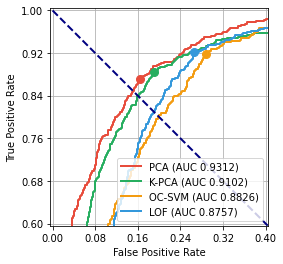

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

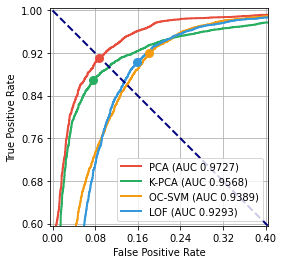

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

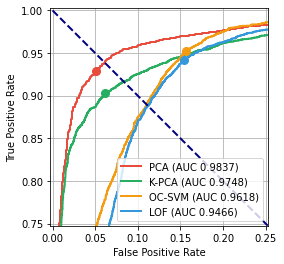

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

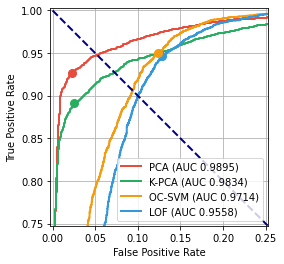

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

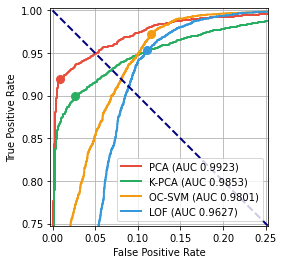

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

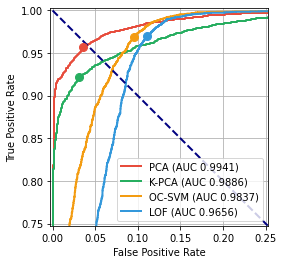

<IPython.core.display.Javascript object>

In [ ]:
# input: rocMat [nDiv x (500 x 2 x nDatasets) x 2]
# output: ROC plot for different values of diversity

import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from google.colab import widgets
from sklearn.metrics import roc_curve, auc

nDiv = 6
nTrainListSize = 4

# PCA
data = io.loadmat('rocMat-pca10-ts50-400.mat')['data']
data = np.delete(data,list(range(nDiv*(nTrainListSize-1))),1)
rocAucPCA = []
fprPCA = []
tprPCA = []
eerPCA = []
balAccXYPCA = []
for iDiv in range(1,nDiv+1):
    fprTmp, tprTmp, _ = roc_curve(data[0,iDiv-1][:, 0], data[0,iDiv-1][:, 1])
    fprPCA.append(fprTmp)
    tprPCA.append(tprTmp)
    rocAucPCA.append(auc(fprTmp, tprTmp))
    fnr = 1 - tprTmp
    eerPCA.append((fprTmp[np.nanargmin(np.absolute((fnr - fprTmp)))]+fnr[np.nanargmin(np.absolute((fnr - fprTmp)))])/2)
    balAcc = (1-fprTmp+tprTmp)/2
    balAccIndex = np.argmax(balAcc)
    balAccXYPCA.append([fprTmp[balAccIndex],tprTmp[balAccIndex]])

# KPCA
data = io.loadmat('rocMat-kpca8-ts50-400.mat')['data']
data = np.delete(data,list(range(nDiv*(nTrainListSize-1))),1)
rocAucKPCA = []
fprKPCA = []
tprKPCA = []
eerKPCA = []
balAccXYKPCA = []
for iDiv in range(1,nDiv+1):
    fprTmp, tprTmp, _ = roc_curve(data[0,iDiv-1][:, 0], data[0,iDiv-1][:, 1])
    fprKPCA.append(fprTmp)
    tprKPCA.append(tprTmp)
    rocAucKPCA.append(auc(fprTmp, tprTmp))
    fnr = 1 - tprTmp
    eerKPCA.append((fprTmp[np.nanargmin(np.absolute((fnr - fprTmp)))]+fnr[np.nanargmin(np.absolute((fnr - fprTmp)))])/2)
    balAcc = (1-fprTmp+tprTmp)/2
    balAccIndex = np.argmax(balAcc)
    balAccXYKPCA.append([fprTmp[balAccIndex],tprTmp[balAccIndex]])

# OCSVM
data = io.loadmat('rocMat-ocsvm-ts50-400.mat')['data']
data = np.delete(data,list(range(nDiv*(nTrainListSize-1))),1)
rocAucOCSVM = []
fprOCVSM = []
tprOCSVM = []
eerOCSVM = []
balAccXYOCSVM = []
for iDiv in range(1,nDiv+1):
    fprTmp, tprTmp, _ = roc_curve(data[0,iDiv-1][:, 0], data[0,iDiv-1][:, 1])
    fprOCVSM.append(fprTmp)
    tprOCSVM.append(tprTmp)
    rocAucOCSVM.append(auc(fprTmp, tprTmp))
    fnr = 1 - tprTmp
    eerOCSVM.append((fprTmp[np.nanargmin(np.absolute((fnr - fprTmp)))]+fnr[np.nanargmin(np.absolute((fnr - fprTmp)))])/2)
    balAcc = (1-fprTmp+tprTmp)/2
    balAccIndex = np.argmax(balAcc)
    balAccXYOCSVM.append([fprTmp[balAccIndex],tprTmp[balAccIndex]])

# LOF
data = io.loadmat('rocMat-lof-ts50-400.mat')['data']
data = np.delete(data,list(range(nDiv*(nTrainListSize-1))),1)
rocAucLOF = []
fprLOF = []
tprLOF = []
eerLOF = []
balAccXYLOF = []
for iDiv in range(1,nDiv+1):
    fprTmp, tprTmp, _ = roc_curve(data[0,iDiv-1][:, 0], data[0,iDiv-1][:, 1])
    fprLOF.append(fprTmp)
    tprLOF.append(tprTmp)
    rocAucLOF.append(auc(fprTmp, tprTmp))
    fnr = 1 - tprTmp
    eerLOF.append((fprTmp[np.nanargmin(np.absolute((fnr - fprTmp)))]+fnr[np.nanargmin(np.absolute((fnr - fprTmp)))])/2)
    balAcc = (1-fprTmp+tprTmp)/2
    balAccIndex = np.argmax(balAcc)
    balAccXYLOF.append([fprTmp[balAccIndex],tprTmp[balAccIndex]])

# ROC Plot
tb = widgets.TabBar(['Div '+str(i) for i in range(1,nDiv+1)])
axesLimAll = [0.40, 0.40, 0.25, 0.25, 0.25, 0.25]

for iDiv in range(nDiv):
    with tb.output_to('Div '+str(iDiv+1)):
        plt.figure()
        plt.axes(aspect='equal')
        lw = 2
        plt.plot(fprPCA[iDiv], tprPCA[iDiv], color='#E74C3C',
                lw=lw, label='PCA (AUC %0.4f)' % rocAucPCA[iDiv]) #, EER %0.4f)' % (rocAucPCA[iDiv], eerPCA[iDiv]))
        plt.plot(fprKPCA[iDiv], tprKPCA[iDiv], color='#27AE60',
                lw=lw, label='K-PCA (AUC %0.4f)' % rocAucKPCA[iDiv]) #, EER %0.4f)' % (rocAucKPCA[iDiv], eerKPCA[iDiv]))
        plt.plot(fprOCVSM[iDiv], tprOCSVM[iDiv], color='#F39C12',
                lw=lw, label='OC-SVM (AUC %0.4f)' % rocAucOCSVM[iDiv]) #, EER %0.4f)' % (rocAucOCSVM[iDiv], eerOCSVM[iDiv]))
        plt.plot(fprLOF[iDiv], tprLOF[iDiv], color='#3498DB',
                lw=lw, label='LOF (AUC %0.4f)' % rocAucLOF[iDiv]) #, EER %0.4f)' % (rocAucLOF[iDiv], eerLOF[iDiv]))
        plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
        plt.plot([balAccXYPCA[iDiv][0]], [balAccXYPCA[iDiv][1]],     marker='o', ms=8, color='#E74C3C')
        plt.plot([balAccXYKPCA[iDiv][0]], [balAccXYKPCA[iDiv][1]],   marker='o', ms=8, color='#27AE60')
        plt.plot([balAccXYLOF[iDiv][0]], [balAccXYLOF[iDiv][1]],     marker='o', ms=8, color='#3498DB')
        plt.plot([balAccXYOCSVM[iDiv][0]], [balAccXYOCSVM[iDiv][1]], marker='o', ms=8, color='#F39C12')
        axesLim = axesLimAll[iDiv]
        plt.xlim([-axesLim/100, axesLim+axesLim/100])
        plt.xticks(np.arange(0, axesLim+axesLim/100, step=axesLim/5)) 
        plt.ylim([1-axesLim-axesLim/100, 1+axesLim/100])
        plt.yticks(np.arange(1-axesLim, 1+axesLim/100, step=axesLim/5)) 
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        #plt.title('ROC curves')
        plt.legend(loc="lower right")
        plt.grid()
        plt.savefig('roc-all-iDiv'+str(iDiv+1)+'.pdf', bbox_inches='tight')

## EER and MBA

Plot the EER and MBA for the four anomaly detectors considered.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

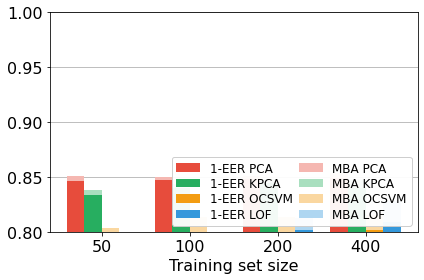

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

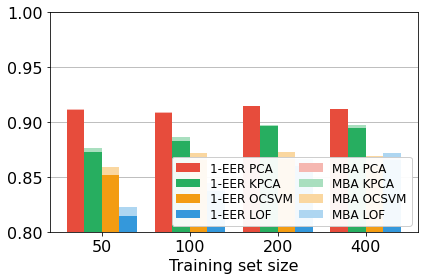

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

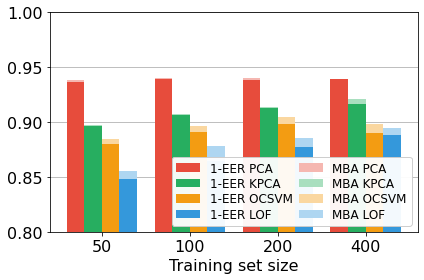

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

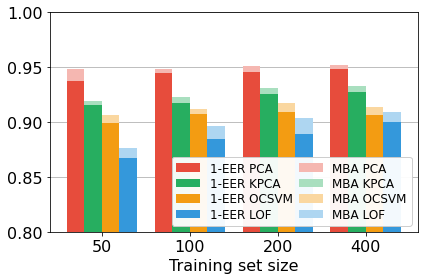

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

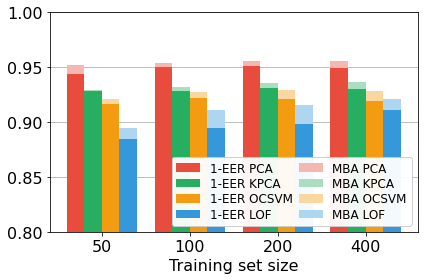

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

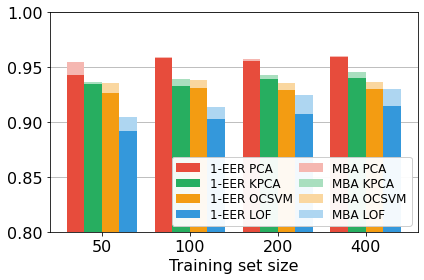

<IPython.core.display.Javascript object>

In [ ]:
# input: rocMat [nDiv x (500 x 2 x nSeeds x nDatasets) x 2]
# output: EER plot for different values of diversity and training size

import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from google.colab import widgets
from sklearn.metrics import roc_curve, auc

nDiv = 6
nTrainList = [50, 100, 200, 400]

# PCA
data = io.loadmat('rocMat-pca10-ts50-400.mat')['data']
fprPCA = []
tprPCA = []
eerPCA = []
balAccPCA = []
for iX in range(len(nTrainList)*nDiv):
    fprTmp, tprTmp, _ = roc_curve(data[0,iX][:, 0], data[0,iX][:, 1])
    fprPCA.append(fprTmp)
    tprPCA.append(tprTmp)
    fnr = 1 - tprTmp
    eerPCA.append((fprTmp[np.nanargmin(np.absolute((fnr - fprTmp)))]+fnr[np.nanargmin(np.absolute((fnr - fprTmp)))])/2)
    balAcc = (1-fprTmp+tprTmp)/2
    balAccPCA.append(np.amax(balAcc))

# KPCA
data = io.loadmat('rocMat-kpca8-ts50-400.mat')['data']
fprKPCA = []
tprKPCA = []
eerKPCA = []
balAccKPCA = []
for iX in range(len(nTrainList)*nDiv):
    fprTmp, tprTmp, _ = roc_curve(data[0,iX][:, 0], data[0,iX][:, 1])
    fprKPCA.append(fprTmp)
    tprKPCA.append(tprTmp)
    fnr = 1 - tprTmp
    eerKPCA.append((fprTmp[np.nanargmin(np.absolute((fnr - fprTmp)))]+fnr[np.nanargmin(np.absolute((fnr - fprTmp)))])/2)
    balAcc = (1-fprTmp+tprTmp)/2
    balAccKPCA.append(np.amax(balAcc))

# OCSVM
data = io.loadmat('rocMat-ocsvm-ts50-400.mat')['data']
fprOCSVM = []
tprOCSVM = []
eerOCSVM = []
balAccOCSVM = []
for iX in range(len(nTrainList)*nDiv):
    fprTmp, tprTmp, _ = roc_curve(data[0,iX][:, 0], data[0,iX][:, 1])
    fprOCSVM.append(fprTmp)
    tprOCSVM.append(tprTmp)
    fnr = 1 - tprTmp
    eerOCSVM.append((fprTmp[np.nanargmin(np.absolute((fnr - fprTmp)))]+fnr[np.nanargmin(np.absolute((fnr - fprTmp)))])/2)
    balAcc = (1-fprTmp+tprTmp)/2
    balAccOCSVM.append(np.amax(balAcc))

# LOF
data = io.loadmat('rocMat-lof-ts50-400.mat')['data']
fprLOF = []
tprLOF = []
eerLOF = []
balAccLOF = []
for iX in range(len(nTrainList)*nDiv):
    fprTmp, tprTmp, _ = roc_curve(data[0,iX][:, 0], data[0,iX][:, 1])
    fprLOF.append(fprTmp)
    tprLOF.append(tprTmp)
    fnr = 1 - tprTmp
    eerLOF.append((fprTmp[np.nanargmin(np.absolute((fnr - fprTmp)))]+fnr[np.nanargmin(np.absolute((fnr - fprTmp)))])/2)
    balAcc = (1-fprTmp+tprTmp)/2
    balAccLOF.append(np.amax(balAcc))

# EER and MBA Plots
tb = widgets.TabBar(['Div '+str(i) for i in range(1,nDiv+1)])

for iDiv in range(nDiv):
    with tb.output_to('Div '+str(iDiv+1)):

        labels = list(nTrainList)
        x = np.arange(len(labels))  # the label locations
        width = 0.2  # the width of the bars
        fig, ax = plt.subplots()
        ax.grid(axis='y', zorder=0)

        eerPCA_bar = []
        eerKPCA_bar = []
        eerOCSVM_bar = []
        eerLOF_bar = []
        for i in range(len(nTrainList)):
            eerPCA_bar.append(1-eerPCA[iDiv+nDiv*i])
            eerKPCA_bar.append(1-eerKPCA[iDiv+nDiv*i])
            eerOCSVM_bar.append(1-eerOCSVM[iDiv+nDiv*i])
            eerLOF_bar.append(1-eerLOF[iDiv+nDiv*i])

        balAccPCA_bar = []
        balAccKPCA_bar = []
        balAccOCSVM_bar = []
        balAccLOF_bar = []
        for i in range(len(nTrainList)):
            balAccPCA_bar.append(balAccPCA[iDiv+nDiv*i])
            balAccKPCA_bar.append(balAccKPCA[iDiv+nDiv*i])
            balAccOCSVM_bar.append(balAccOCSVM[iDiv+nDiv*i])
            balAccLOF_bar.append(balAccLOF[iDiv+nDiv*i])

        rects1 = ax.bar(x - 3*width/2, eerPCA_bar     , width, label='1-EER PCA', zorder=3, color = '#E74C3C')
        rects7 = ax.bar(x - width/2  , eerKPCA_bar    , width, label='1-EER KPCA', zorder=3, color = '#27AE60')
        rects5 = ax.bar(x + width/2  , eerOCSVM_bar   , width, label='1-EER OCSVM', zorder=3, color = '#F39C12')
        rects3 = ax.bar(x + 3*width/2, eerLOF_bar     , width, label='1-EER LOF', zorder=3, color = '#3498DB')
        rects2 = ax.bar(x - 3*width/2, balAccPCA_bar  , width, label='MBA PCA', zorder=2, color = '#F5B7B1')
        rects8 = ax.bar(x - width/2  , balAccKPCA_bar , width, label='MBA KPCA', zorder=2, color = '#A9DFBF')
        rects6 = ax.bar(x + width/2  , balAccOCSVM_bar, width, label='MBA OCSVM', zorder=2, color = '#FAD7A0')
        rects4 = ax.bar(x + 3*width/2, balAccLOF_bar  , width, label='MBA LOF', zorder=2, color = '#AED6F1')

        ax.set_xlabel('Training set size', fontsize=16)
        #ax.set_ylabel('1 - Equal Error Rate')
        #ax.set_title('Performance on single digit with different diversity')
        ax.set_xticks(x)
        plt.xticks(fontsize=16)
        ax.set_xticklabels(labels)
        ax.set_ylim((0.8, 1))
        ax.set_yticks(np.linspace(0.8, 1, num=5))
        plt.yticks(fontsize=16)
        ax.legend(labelspacing=0.2, ncol=2, columnspacing=0.5, framealpha=0.95, loc="lower right", fontsize=12)
        fig.tight_layout()
        plt.savefig('roc-eer-mba-all-iDiv'+str(iDiv+1)+'.pdf', bbox_inches='tight')

## Denial of access probability

Plot the Denial of access probability for the four anomaly detectors considered.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

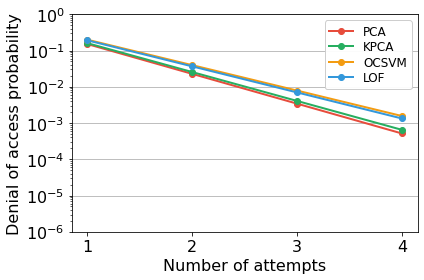

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

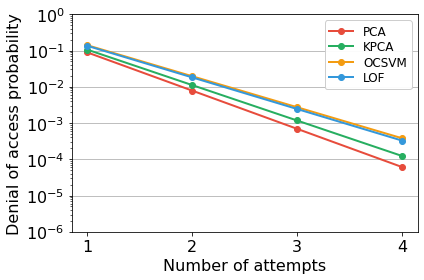

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

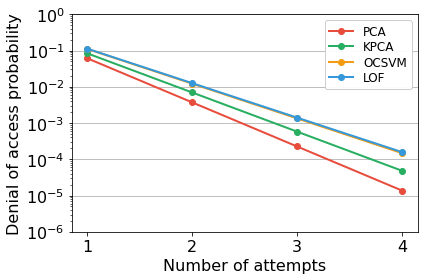

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

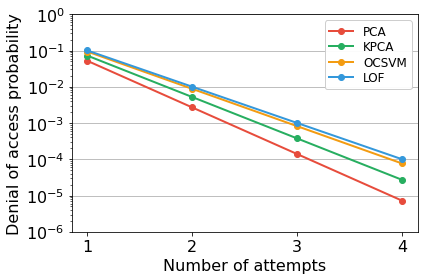

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

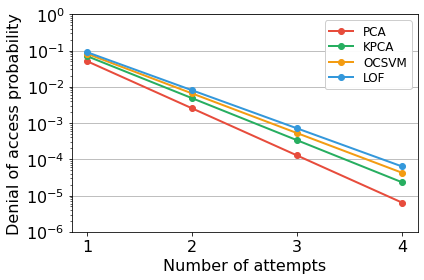

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

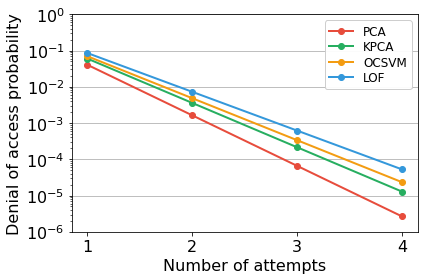

<IPython.core.display.Javascript object>

In [ ]:
nAttempts = 4
iTrainList = 3 # Consider training size 400

attempts = np.arange(nAttempts)
tb = widgets.TabBar(['Div '+str(i) for i in range(1,nDiv+1)])

for iDiv in range(nDiv):
    with tb.output_to('Div '+str(iDiv+1)):

        fig, ax = plt.subplots()

        doa_probPCA = eerPCA[iDiv+nDiv*iTrainList] ** (attempts + 1)
        doa_probKPCA = eerKPCA[iDiv+nDiv*iTrainList] ** (attempts + 1)
        doa_probOCSVM = eerOCSVM[iDiv+nDiv*iTrainList] ** (attempts + 1)
        doa_probLOF = eerLOF[iDiv+nDiv*iTrainList] ** (attempts + 1)

        plt.plot(doa_probPCA  , '-o', color = '#E74C3C', lw=lw, label='PCA')
        plt.plot(doa_probKPCA , '-o', color = '#27AE60', lw=lw, label='KPCA')
        plt.plot(doa_probOCSVM, '-o', color = '#F39C12', lw=lw, label='OCSVM')
        plt.plot(doa_probLOF  , '-o', color = '#3498DB', lw=lw, label='LOF')

        ax.set_xlabel('Number of attempts', fontsize=16)
        ax.set_ylabel('Denial of access probability', fontsize=16)
        ax.set_xticks(attempts)
        plt.xticks(fontsize=16)
        ax.set_xticklabels(attempts+1)
        ax.set_yscale('log')
        ax.set_ylim((1e-6, 1))
        plt.yticks(fontsize=16)
        ax.grid(axis='y')

        ax.legend(labelspacing=0.2, framealpha=0.95, loc='best', fontsize=12)
        fig.tight_layout()
        plt.savefig('doa-prob-all-iDiv'+str(iDiv+1)+'.pdf', bbox_inches='tight')

## Processing time

Plot the processing time for the four anomaly detectors considered.

In [ ]:
import numpy as np
from scipy import io

dataPCA = np.mean(io.loadmat('times-pca10-ts400.mat')['data'],1) / 500 * 1e3
dataKPCA = np.mean(io.loadmat('times-kpca8-ts400.mat')['data'],1) / 500 * 1e3
dataOCSVM = np.mean(io.loadmat('times-ocsvm-ts400.mat')['data'],1) / 500 * 1e3
dataLOF = np.mean(io.loadmat('times-lof-ts400.mat')['data'],1) / 500 * 1e3

print('PCA: ',      dataPCA[[2,3,5]])
print('K-PCA: ',    dataKPCA[[2,3,5]])
print('OC-SVM: ',   dataOCSVM[[2,3,5]])
print('LOF: ',      dataLOF[[2,3,5]])

PCA:  [0.10432923 0.12220836 0.10794791]
K-PCA:  [0.90685101 0.93087892 0.99309731]
OC-SVM:  [0.14325909 0.15207215 0.16494679]
LOF:  [0.62292608 0.62965842 0.63124247]
